In [1]:
import os
import torch
import torchvision
from torch.utils.data import random_split
from torchvision import datasets
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )

In [4]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [6]:
def show_example(img, label):
    print('Label: ', trainset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  frog (6)


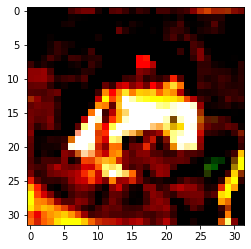

In [7]:
show_example(*trainset[0])

Label:  automobile (1)


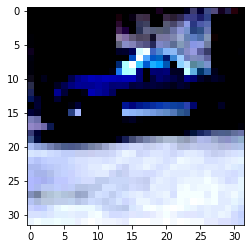

In [8]:
show_example(*trainset[10000])

# Training and Validation Datasets

In [9]:
random_seed = 239
torch.manual_seed(random_seed);

In [10]:
val_size = 5000
train_size = len(trainset) - val_size

train_ds, val_ds = random_split(trainset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [11]:
from torch.utils.data.dataloader import DataLoader

batch_size=128

In [12]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, pin_memory=True)

In [13]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

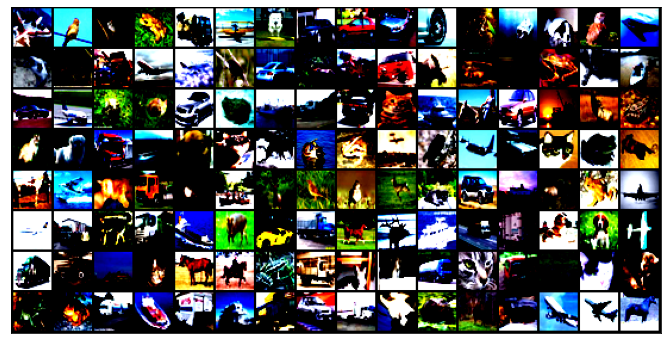

In [14]:
show_batch(train_dl)

# Building the CNN Model

In [15]:
import torch.nn as nn
import torch.nn.functional as F

In [16]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)
        return loss, acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_acc: {:.4f}, val_acc: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}".format(
            epoch, result['train_acc'], result['val_acc'], result['train_loss'], result['val_loss']))
        
def accuracy(outputs, labels):
    preds = torch.argmax(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [17]:
class CNN_base(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 32 x 16 x 16

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 8 x 8

            nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 96 x 4 x 4

            nn.Flatten(), 
            nn.Linear(96*4*4, 64),
            nn.ReLU(),
            nn.Linear(64, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [18]:
model = CNN_base()
model

CNN_base(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1536, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=10, bias=True)
  )
)

# Integrating with GPU

In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:
device = get_default_device()
device

device(type='cuda')

In [21]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

# Training the Model

In [22]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_accs = []
        for batch in train_loader:
            loss, acc = model.training_step(batch)
            train_losses.append(loss)
            train_accs.append(acc)
            
            # Compute gradients
            loss.backward()

            # Update parameters
            optimizer.step()

            # Reset gradients
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accs).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [23]:
from torchsummary import summary

In [24]:
model = to_device(CNN_base(), device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 96, 8, 8]          55,392
              ReLU-8             [-1, 96, 8, 8]               0
         MaxPool2d-9             [-1, 96, 4, 4]               0
          Flatten-10                 [-1, 1536]               0
           Linear-11                   [-1, 64]          98,368
             ReLU-12                   [-1, 64]               0
           Linear-13                   [-1, 10]             650
Total params: 173,802
Trainable params:

# Experiments on the Baseline

# Varying learning rate

In [26]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001

In [27]:
%%time
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_acc: 0.4559, val_acc: 0.5672, train_loss: 1.4978, val_loss: 1.1901
Epoch [1], train_acc: 0.6167, val_acc: 0.6430, train_loss: 1.0766, val_loss: 1.0200
Epoch [2], train_acc: 0.6833, val_acc: 0.6716, train_loss: 0.9004, val_loss: 0.9202
Epoch [3], train_acc: 0.7207, val_acc: 0.7046, train_loss: 0.7941, val_loss: 0.8523
Epoch [4], train_acc: 0.7536, val_acc: 0.7219, train_loss: 0.7062, val_loss: 0.8007
Epoch [5], train_acc: 0.7797, val_acc: 0.7277, train_loss: 0.6355, val_loss: 0.7900
Epoch [6], train_acc: 0.7979, val_acc: 0.7394, train_loss: 0.5776, val_loss: 0.7748
Epoch [7], train_acc: 0.8177, val_acc: 0.7378, train_loss: 0.5185, val_loss: 0.7972
Epoch [8], train_acc: 0.8326, val_acc: 0.7440, train_loss: 0.4719, val_loss: 0.7917
Epoch [9], train_acc: 0.8510, val_acc: 0.7390, train_loss: 0.4244, val_loss: 0.8132
Epoch [10], train_acc: 0.8675, val_acc: 0.7329, train_loss: 0.3748, val_loss: 0.8905
Epoch [11], train_acc: 0.8787, val_acc: 0.7356, train_loss: 0.3433, val_los

In [28]:
def plot_accuracies(history):
    train_accuracies = [x['train_acc'] for x in history]
    val_accuracies = [x['val_acc'] for x in history]
    plt.plot(train_accuracies, '-bx')
    plt.plot(val_accuracies, '-rx')    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');

In [29]:
def plot_losses(history):
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

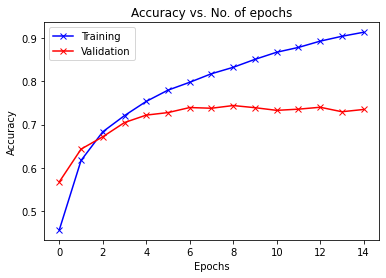

In [122]:
plot_accuracies(history)

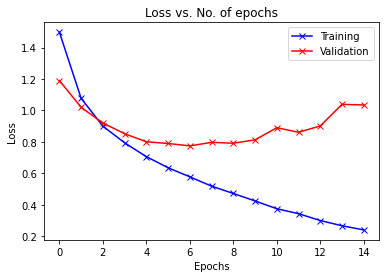

In [123]:
plot_losses(history)

In [30]:
evaluate(model, val_dl)

{'val_loss': 1.0350794792175293, 'val_acc': 0.7349149584770203}

In [31]:
base2 = to_device(CNN_base(), device)
summary(base2, (3, 32, 32))

num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.01

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 96, 8, 8]          55,392
              ReLU-8             [-1, 96, 8, 8]               0
         MaxPool2d-9             [-1, 96, 4, 4]               0
          Flatten-10                 [-1, 1536]               0
           Linear-11                   [-1, 64]          98,368
             ReLU-12                   [-1, 64]               0
           Linear-13                   [-1, 10]             650
Total params: 173,802
Trainable params:

In [32]:
%%time
history_base2 = fit(num_epochs, lr, base2, train_dl, val_dl, opt_func)

Epoch [0], train_acc: 0.3384, val_acc: 0.4279, train_loss: 1.8165, val_loss: 1.5521
Epoch [1], train_acc: 0.4358, val_acc: 0.4534, train_loss: 1.5473, val_loss: 1.4925
Epoch [2], train_acc: 0.4521, val_acc: 0.4759, train_loss: 1.5019, val_loss: 1.4523
Epoch [3], train_acc: 0.4694, val_acc: 0.4682, train_loss: 1.4670, val_loss: 1.4609
Epoch [4], train_acc: 0.4745, val_acc: 0.4813, train_loss: 1.4569, val_loss: 1.4477
Epoch [5], train_acc: 0.4798, val_acc: 0.4820, train_loss: 1.4435, val_loss: 1.4353
Epoch [6], train_acc: 0.4843, val_acc: 0.4752, train_loss: 1.4277, val_loss: 1.4576
Epoch [7], train_acc: 0.4811, val_acc: 0.4795, train_loss: 1.4314, val_loss: 1.4604
Epoch [8], train_acc: 0.4859, val_acc: 0.4826, train_loss: 1.4187, val_loss: 1.4290
Epoch [9], train_acc: 0.4863, val_acc: 0.4682, train_loss: 1.4178, val_loss: 1.4515
Epoch [10], train_acc: 0.4923, val_acc: 0.4663, train_loss: 1.4085, val_loss: 1.4855
Epoch [11], train_acc: 0.4976, val_acc: 0.4772, train_loss: 1.4001, val_los

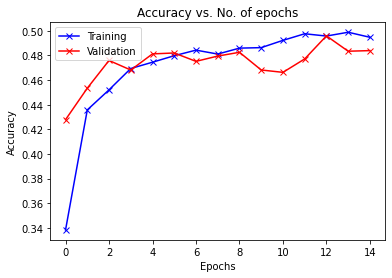

In [33]:
plot_accuracies(history_base2)

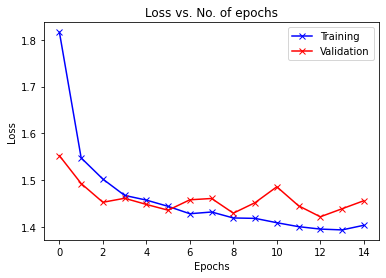

In [34]:
plot_losses(history_base2)

In [35]:
evaluate(base2, val_dl)

{'val_loss': 1.4555671215057373, 'val_acc': 0.483926922082901}

In [36]:
base3 = to_device(CNN_base(), device)
summary(base3, (3, 32, 32))

num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.0001

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 96, 8, 8]          55,392
              ReLU-8             [-1, 96, 8, 8]               0
         MaxPool2d-9             [-1, 96, 4, 4]               0
          Flatten-10                 [-1, 1536]               0
           Linear-11                   [-1, 64]          98,368
             ReLU-12                   [-1, 64]               0
           Linear-13                   [-1, 10]             650
Total params: 173,802
Trainable params:

In [37]:
%%time
history_base3 = fit(num_epochs, lr, base3, train_dl, val_dl, opt_func)

Epoch [0], train_acc: 0.3297, val_acc: 0.4314, train_loss: 1.8629, val_loss: 1.6011
Epoch [1], train_acc: 0.4642, val_acc: 0.4929, train_loss: 1.4975, val_loss: 1.4160
Epoch [2], train_acc: 0.5098, val_acc: 0.5247, train_loss: 1.3786, val_loss: 1.3381
Epoch [3], train_acc: 0.5367, val_acc: 0.5429, train_loss: 1.3114, val_loss: 1.2892
Epoch [4], train_acc: 0.5579, val_acc: 0.5628, train_loss: 1.2566, val_loss: 1.2283
Epoch [5], train_acc: 0.5764, val_acc: 0.5825, train_loss: 1.2072, val_loss: 1.1727
Epoch [6], train_acc: 0.5942, val_acc: 0.6000, train_loss: 1.1617, val_loss: 1.1458
Epoch [7], train_acc: 0.6088, val_acc: 0.6076, train_loss: 1.1227, val_loss: 1.1131
Epoch [8], train_acc: 0.6210, val_acc: 0.6213, train_loss: 1.0878, val_loss: 1.0727
Epoch [9], train_acc: 0.6337, val_acc: 0.6294, train_loss: 1.0578, val_loss: 1.0493
Epoch [10], train_acc: 0.6414, val_acc: 0.6391, train_loss: 1.0298, val_loss: 1.0300
Epoch [11], train_acc: 0.6501, val_acc: 0.6410, train_loss: 1.0051, val_los

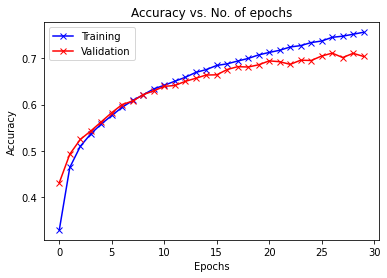

In [38]:
plot_accuracies(history_base3)

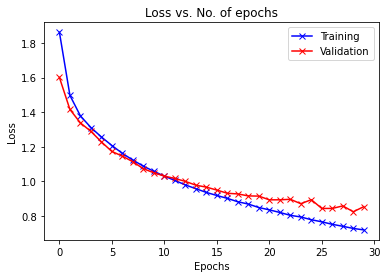

In [39]:
plot_losses(history_base3)

In [40]:
evaluate(base3, val_dl)

{'val_loss': 0.8531797528266907, 'val_acc': 0.7035616040229797}

## With Batchnorm

In [41]:
class CNN_batchnorm(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 8 x 8

            nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 96 x 4 x 4

            nn.Flatten(), 
            nn.Linear(96*4*4, 64),
            nn.ReLU(),
            nn.Linear(64, 10))
       
    def forward(self, xb):
        return self.network(xb)

In [42]:
model2 = to_device(CNN_batchnorm(), device)
summary(model2, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 96, 8, 8]          55,392
      BatchNorm2d-10             [-1, 96, 8, 8]             192
             ReLU-11             [-1, 96, 8, 8]               0
        MaxPool2d-12             [-1, 96, 4, 4]               0
          Flatten-13                 [-1, 1536]               0
           Linear-14                   

In [43]:
%%time
history2 = fit(num_epochs, lr, model2, train_dl, val_dl, opt_func)

Epoch [0], train_acc: 0.4554, val_acc: 0.5576, train_loss: 1.5577, val_loss: 1.2653
Epoch [1], train_acc: 0.5952, val_acc: 0.6102, train_loss: 1.1612, val_loss: 1.1057
Epoch [2], train_acc: 0.6528, val_acc: 0.6616, train_loss: 1.0034, val_loss: 0.9808
Epoch [3], train_acc: 0.6870, val_acc: 0.6772, train_loss: 0.9074, val_loss: 0.9313
Epoch [4], train_acc: 0.7102, val_acc: 0.6925, train_loss: 0.8410, val_loss: 0.8866
Epoch [5], train_acc: 0.7294, val_acc: 0.6942, train_loss: 0.7903, val_loss: 0.8794
Epoch [6], train_acc: 0.7458, val_acc: 0.7119, train_loss: 0.7451, val_loss: 0.8381
Epoch [7], train_acc: 0.7601, val_acc: 0.7279, train_loss: 0.7050, val_loss: 0.8078
Epoch [8], train_acc: 0.7720, val_acc: 0.7257, train_loss: 0.6709, val_loss: 0.7940
Epoch [9], train_acc: 0.7859, val_acc: 0.7378, train_loss: 0.6368, val_loss: 0.7738
Epoch [10], train_acc: 0.7957, val_acc: 0.7314, train_loss: 0.6082, val_loss: 0.7736
Epoch [11], train_acc: 0.8061, val_acc: 0.7341, train_loss: 0.5799, val_los

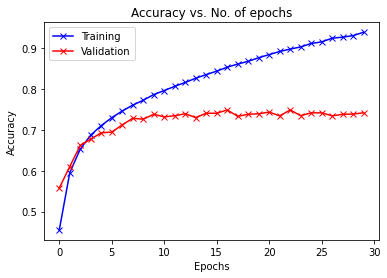

In [44]:
plot_accuracies(history2)

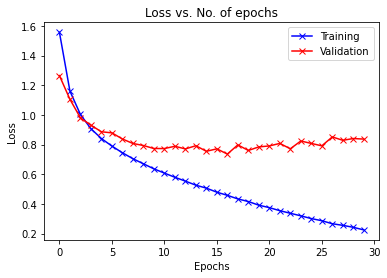

In [45]:
plot_losses(history2)

In [121]:
evaluate(model2, val_dl)

{'val_loss': 0.837384045124054, 'val_acc': 0.7413603067398071}

## With dropout

In [46]:
class CNN_batchnorm_dropout(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 8 x 8

            nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 96 x 4 x 4

            nn.Flatten(), 
            nn.Linear(96*4*4, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 10))

    def forward(self, xb):
        return self.network(xb)


In [47]:
model3 = to_device(CNN_batchnorm_dropout(), device)
summary(model3, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 96, 8, 8]          55,392
      BatchNorm2d-10             [-1, 96, 8, 8]             192
             ReLU-11             [-1, 96, 8, 8]               0
        MaxPool2d-12             [-1, 96, 4, 4]               0
          Flatten-13                 [-1, 1536]               0
           Linear-14                   

In [48]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

In [49]:
%%time
history3 = fit(num_epochs, lr, model3, train_dl, val_dl, opt_func)

Epoch [0], train_acc: 0.4954, val_acc: 0.6095, train_loss: 1.3847, val_loss: 1.1074
Epoch [1], train_acc: 0.6419, val_acc: 0.6733, train_loss: 1.0122, val_loss: 0.9414
Epoch [2], train_acc: 0.6909, val_acc: 0.7294, train_loss: 0.8824, val_loss: 0.7954
Epoch [3], train_acc: 0.7200, val_acc: 0.7066, train_loss: 0.7947, val_loss: 0.8280
Epoch [4], train_acc: 0.7413, val_acc: 0.7527, train_loss: 0.7363, val_loss: 0.7185
Epoch [5], train_acc: 0.7612, val_acc: 0.7604, train_loss: 0.6796, val_loss: 0.7063
Epoch [6], train_acc: 0.7771, val_acc: 0.7400, train_loss: 0.6302, val_loss: 0.7450
Epoch [7], train_acc: 0.7914, val_acc: 0.7352, train_loss: 0.5938, val_loss: 0.7919
Epoch [8], train_acc: 0.8045, val_acc: 0.7523, train_loss: 0.5570, val_loss: 0.7415
Epoch [9], train_acc: 0.8148, val_acc: 0.7595, train_loss: 0.5242, val_loss: 0.7233
Epoch [10], train_acc: 0.8301, val_acc: 0.7688, train_loss: 0.4783, val_loss: 0.7189
Epoch [11], train_acc: 0.8389, val_acc: 0.7778, train_loss: 0.4488, val_los

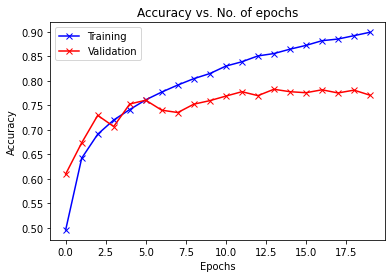

In [50]:
plot_accuracies(history3)

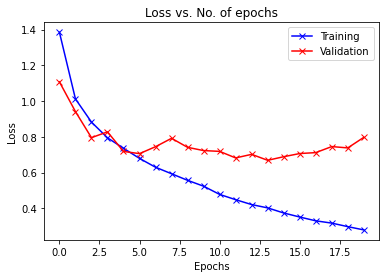

In [51]:
plot_losses(history3)

In [120]:
evaluate(model3, val_dl)

{'val_loss': 0.797144889831543, 'val_acc': 0.770622730255127}

# Data Transformation + Augmentation

In [53]:
import torchvision.transforms as tt

# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)])
test_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [54]:
trainset_t = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_tfms)
testset_t = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_tfms)

Files already downloaded and verified
Files already downloaded and verified


In [55]:
trainset_t

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )

In [56]:
# PyTorch datasets
# train_trans = ImageFolder(data_dir+'/train', transform = train_tfms)
# test_trans = ImageFolder(data_dir+'/test', test_tfms)

In [57]:
val_size = 5000
train_size = len(trainset_t) - val_size

train_ds_t, val_ds_t = random_split(trainset_t, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [58]:
batch_size = 400

# PyTorch data loaders
train_dl_t = DataLoader(train_ds_t, batch_size, shuffle=True, pin_memory=True)
val_dl_t = DataLoader(val_ds_t, batch_size*2, pin_memory=True)
test_dl_t = DataLoader(testset_t, batch_size*2, pin_memory=True)

train_dl_t = DeviceDataLoader(train_dl_t, device)
val_dl_t = DeviceDataLoader(val_dl_t, device)

In [59]:
model4 = to_device(CNN_batchnorm_dropout(), device)
summary(model4, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 96, 8, 8]          55,392
      BatchNorm2d-10             [-1, 96, 8, 8]             192
             ReLU-11             [-1, 96, 8, 8]               0
        MaxPool2d-12             [-1, 96, 4, 4]               0
          Flatten-13                 [-1, 1536]               0
           Linear-14                   

In [60]:
num_epochs = 25
opt_func = torch.optim.Adam
lr = 0.001

In [61]:
%%time
history4 = fit(num_epochs, lr, model4, train_dl_t, val_dl_t, opt_func)

Epoch [0], train_acc: 0.4189, val_acc: 0.5111, train_loss: 1.5839, val_loss: 1.3264
Epoch [1], train_acc: 0.5514, val_acc: 0.6127, train_loss: 1.2424, val_loss: 1.0988
Epoch [2], train_acc: 0.6074, val_acc: 0.6098, train_loss: 1.0958, val_loss: 1.1390
Epoch [3], train_acc: 0.6357, val_acc: 0.6500, train_loss: 1.0206, val_loss: 0.9900
Epoch [4], train_acc: 0.6582, val_acc: 0.6534, train_loss: 0.9648, val_loss: 0.9818
Epoch [5], train_acc: 0.6770, val_acc: 0.6680, train_loss: 0.9198, val_loss: 0.9525
Epoch [6], train_acc: 0.6896, val_acc: 0.7012, train_loss: 0.8803, val_loss: 0.8597
Epoch [7], train_acc: 0.6973, val_acc: 0.6925, train_loss: 0.8567, val_loss: 0.8672
Epoch [8], train_acc: 0.7086, val_acc: 0.7261, train_loss: 0.8301, val_loss: 0.7786
Epoch [9], train_acc: 0.7147, val_acc: 0.7063, train_loss: 0.8063, val_loss: 0.8201
Epoch [10], train_acc: 0.7244, val_acc: 0.6952, train_loss: 0.7903, val_loss: 0.8614
Epoch [11], train_acc: 0.7329, val_acc: 0.7032, train_loss: 0.7649, val_los

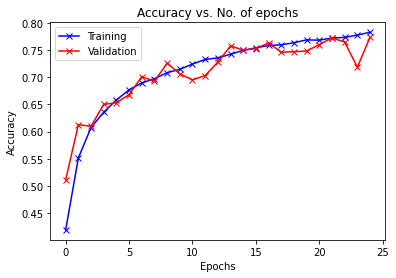

In [62]:
plot_accuracies(history4)

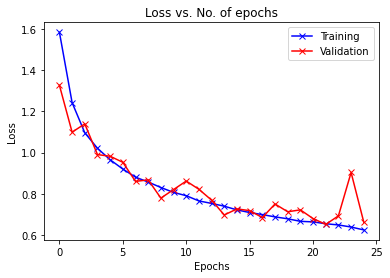

In [63]:
plot_losses(history4)

In [118]:
evaluate(model4, val_dl_t)

{'val_loss': 0.6513118147850037, 'val_acc': 0.7842856645584106}

# Residual Network

In [64]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [77]:
resnet9 = to_device(ResNet9(3, 10), device)
summary(resnet9, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

In [78]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

In [79]:
history5 = fit(num_epochs, lr, resnet9, train_dl_t, val_dl_t, opt_func)

Epoch [0], train_acc: 0.4584, val_acc: 0.5455, train_loss: 1.5489, val_loss: 1.3706
Epoch [1], train_acc: 0.6503, val_acc: 0.7000, train_loss: 0.9912, val_loss: 0.8812
Epoch [2], train_acc: 0.7305, val_acc: 0.7713, train_loss: 0.7723, val_loss: 0.6620
Epoch [3], train_acc: 0.7759, val_acc: 0.7427, train_loss: 0.6447, val_loss: 0.7459
Epoch [4], train_acc: 0.8044, val_acc: 0.7236, train_loss: 0.5661, val_loss: 0.9091
Epoch [5], train_acc: 0.8284, val_acc: 0.8127, train_loss: 0.4993, val_loss: 0.5508
Epoch [6], train_acc: 0.8454, val_acc: 0.8366, train_loss: 0.4479, val_loss: 0.4770
Epoch [7], train_acc: 0.8606, val_acc: 0.8380, train_loss: 0.4058, val_loss: 0.4779
Epoch [8], train_acc: 0.8712, val_acc: 0.8491, train_loss: 0.3742, val_loss: 0.4592
Epoch [9], train_acc: 0.8807, val_acc: 0.8279, train_loss: 0.3435, val_loss: 0.5303
Epoch [10], train_acc: 0.8895, val_acc: 0.8354, train_loss: 0.3185, val_loss: 0.5332
Epoch [11], train_acc: 0.8984, val_acc: 0.8643, train_loss: 0.2933, val_los

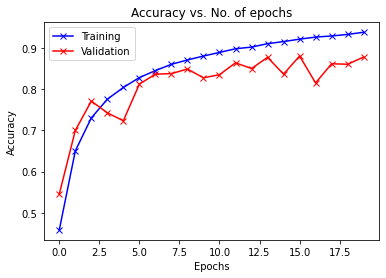

In [80]:
plot_accuracies(history5)

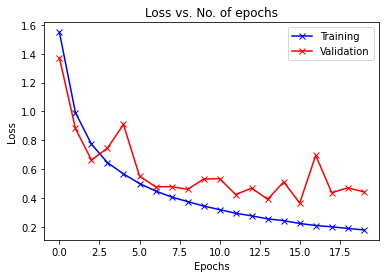

In [81]:
plot_losses(history5)

In [117]:
evaluate(resnet9, val_dl_t)

{'val_loss': 0.4259267747402191, 'val_acc': 0.8800000548362732}

# Transfer Learning (Using pretrained models with weights)

In [105]:
from torchvision import models

In [106]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=.40),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(*stats,inplace=True)])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(*stats,inplace=True)])

traindata = torchvision.datasets.CIFAR10(root='.', train=True,download=True, transform=train_transform)
trainset,valset = random_split(traindata,[45000,5000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=400,shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=400,shuffle=False)

testset = torchvision.datasets.CIFAR10(root='.', train=False,download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=400,shuffle=False)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [107]:
trainloader = DeviceDataLoader(trainloader, device)
valloader = DeviceDataLoader(valloader, device)
testloader = DeviceDataLoader(testloader, device)

In [108]:
class ResNet18(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        base = models.resnet18(pretrained=True)
        self.base = nn.Sequential(*list(base.children())[:-1])
        in_features = base.fc.in_features
        self.drop = nn.Dropout()
        self.final = nn.Linear(in_features,10)
    
    def forward(self,x):
        x = self.base(x)
        x = self.drop(x.view(-1,self.final.in_features))
        return self.final(x)

In [109]:
resnet18 = to_device(ResNet18(), device)
summary(resnet18, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [110]:
evaluate(resnet18, testloader)

{'val_loss': 2.5591626167297363, 'val_acc': 0.06209999695420265}

In [111]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001

In [112]:
%%time
history_resnet18 = fit(num_epochs, lr, resnet18, trainloader, valloader, opt_func)

Epoch [0], train_acc: 0.8100, val_acc: 0.8581, train_loss: 0.5538, val_loss: 0.3989
Epoch [1], train_acc: 0.8894, val_acc: 0.8744, train_loss: 0.3210, val_loss: 0.3636
Epoch [2], train_acc: 0.9131, val_acc: 0.8867, train_loss: 0.2535, val_loss: 0.3338
Epoch [3], train_acc: 0.9257, val_acc: 0.8896, train_loss: 0.2197, val_loss: 0.3439
Epoch [4], train_acc: 0.9368, val_acc: 0.9027, train_loss: 0.1839, val_loss: 0.2904
Epoch [5], train_acc: 0.9417, val_acc: 0.9021, train_loss: 0.1681, val_loss: 0.3061
Epoch [6], train_acc: 0.9496, val_acc: 0.9098, train_loss: 0.1440, val_loss: 0.2637
Epoch [7], train_acc: 0.9515, val_acc: 0.9140, train_loss: 0.1375, val_loss: 0.2583
Epoch [8], train_acc: 0.9577, val_acc: 0.9162, train_loss: 0.1204, val_loss: 0.2660
Epoch [9], train_acc: 0.9619, val_acc: 0.9131, train_loss: 0.1097, val_loss: 0.2801
Epoch [10], train_acc: 0.9631, val_acc: 0.9012, train_loss: 0.1055, val_loss: 0.3368
Epoch [11], train_acc: 0.9667, val_acc: 0.9177, train_loss: 0.0982, val_los

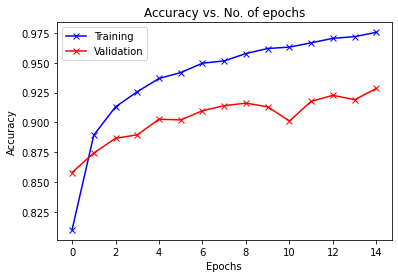

In [113]:
plot_accuracies(history_resnet18)

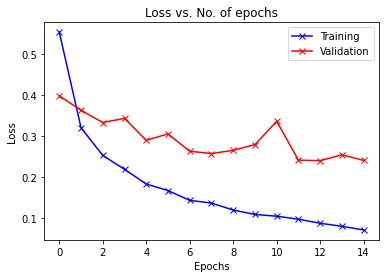

In [114]:
plot_losses(history_resnet18)

In [115]:
evaluate(resnet18, valloader)

{'val_loss': 0.2407757043838501, 'val_acc': 0.928076982498169}

In [116]:
evaluate(resnet18, testloader)

{'val_loss': 0.22597669064998627, 'val_acc': 0.9372999668121338}